### MScFE 690 Capstone -- Submission 4

#### Install and imports

In [1]:
import nolds
import pandas as pd
import numpy as np
import math
from fbm import *
from fbm import FBM
import yfinance as yf
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')
mpl.rcParams['font.family'] = 'arial'

The MMAR or Multifractal Model of Asset Returns utilizes a compound process denoted as \(X(t)\). This is presented mathematically as:

$$ X(t) = B_H(\theta(t)) $$

Here are the components of the equation:

- \(X(t)\) is our compound process. This signifies the cumulative effect of multiple time scales.
- \(B_H(t)\) is what we call a fractional Brownian motion. This is a variation of a Gaussian process and a generalization of the standard Brownian motion. The Hurst exponent, denoted by \(H\) (with \(0 < H < 1\)), characterizes this motion. A Hurst exponent of \(0.5\) turns \(B_H(t)\) into a standard Brownian motion, while a Hurst exponent less than \(0.5\) indicates negative correlation in the process increments, and a Hurst exponent greater than \(0.5\) suggests positive correlation.
- Lastly, \(\theta(t)\) corresponds to the cumulative distribution function of a specific multifractal cascade measure. This is crucial as it dictates the changing "pace" of the fractional Brownian motion. The precise form of \(\theta(t)\) is contingent on the multifractal cascade measure in use, which itself depends on the distinct properties of the financial time series under study.

#### A Look a Fractal Brownian Motion

In [2]:
fbm = nolds.fbm(100, H=0.75)

In [3]:
fbm = pd.Series(fbm)

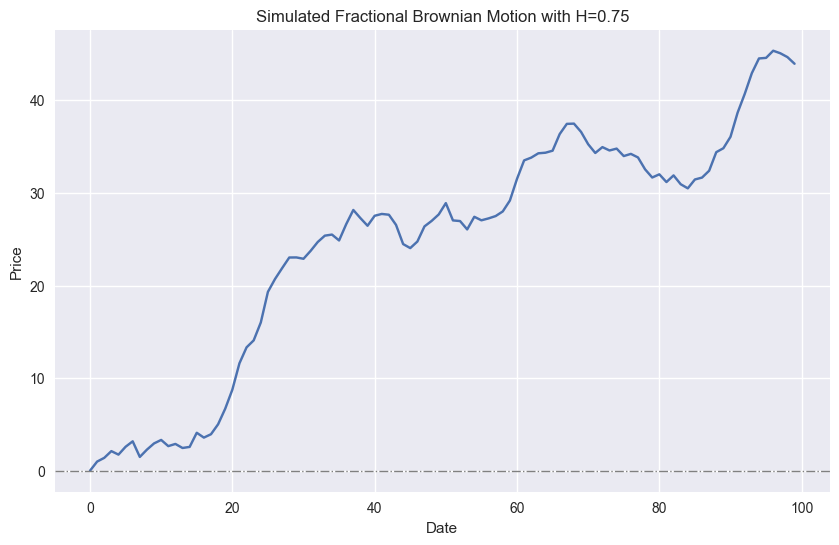

In [4]:
plt.figure(figsize=(10, 6))
plt.plot(fbm)
plt.axhline(y=0.0, color='grey', linestyle='-.', linewidth=1)
plt.title('Simulated Fractional Brownian Motion with H=0.75')
# plt.legend(loc=0)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

#### Importing Oil Prices

In [5]:
ticker_symbol = 'CL=F'
start_date = '1990-01-01'
end_date = '2023-06-30'
data = yf.download(ticker_symbol, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [6]:
prices = data['Adj Close']

In [7]:
prices.describe()

count    5736.000000
mean       63.826939
std        25.616539
min       -37.630001
25%        44.480000
50%        61.445000
75%        83.642498
max       145.289993
Name: Adj Close, dtype: float64

#### Calculating Oil's Hurst Exponent

In [8]:
oil_h = nolds.hurst_rs(prices)

In [9]:
oil_h

0.9541398339283186

In [10]:
oil_fd = nolds.corr_dim(prices, 1)

In [11]:
oil_h + oil_fd # D = H - 2

1.9082212626263733

#### Simulating A FBM with Oil's H

In [12]:
fbm_oil = nolds.fbm(100, H=oil_h)

In [13]:
fbm_oil = pd.Series(fbm_oil)

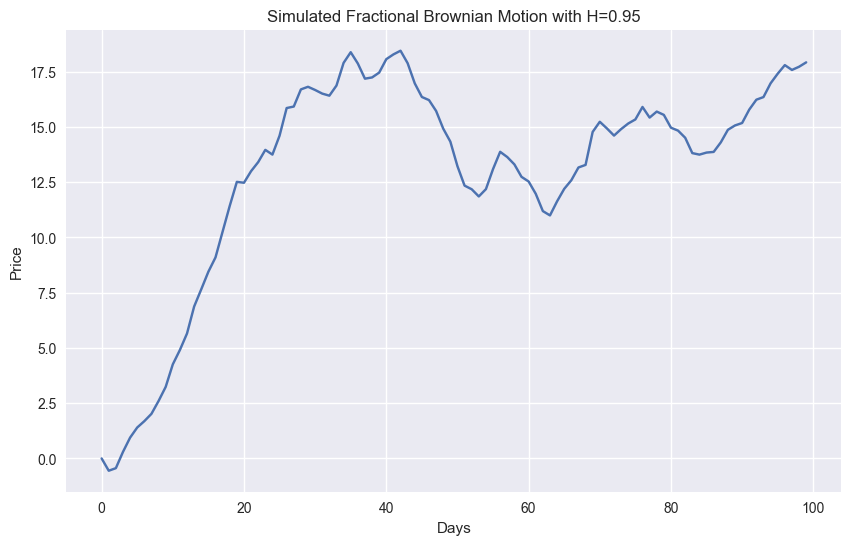

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(fbm_oil)
#plt.axhline(y=0.0, color='grey', linestyle='-.', linewidth=1)
plt.title('Simulated Fractional Brownian Motion with H=0.95')
# plt.legend(loc=0)
plt.xlabel('Days')
plt.ylabel('Price')
plt.show()

To examplify the process of pricing an option using Monte Carlo simulation from a given stochastic model, we will attempt to price an European call option under the assumption that the price of the asset follows a fractional Brownian Motion process (fbm). We will later use the same methodology to calculate the payoff and discounted value for the MMAR simulations:

In [15]:
# parameters
N = 100000
H = 0.60
S0 = 100  
K = 100  
T = 1.0  
r = 0.05  

# FBM
f = FBM(n=N-1, hurst=H, length=T, method='daviesharte')

# Fractional Brownian motion 
fbm_sample = f.fbm()

# Vol and Stdev
sigma = np.std(fbm_sample)

# Function for path simulation
def simulate_path(S0, T, sigma, N, fbm_sample):
    dt = T/(N-1)
    return S0 * np.exp((r - 0.5*sigma**2)*np.linspace(0, T, N) + sigma*fbm_sample)

# paths
num_paths = 100000

# simulate price paths and calculate payoffs
payoffs = []
for _ in range(num_paths):
    path = simulate_path(S0, T, sigma, N, fbm_sample)
    payoff = np.maximum(path[-1] - K, 0)  # This is for a call option
    payoffs.append(payoff)

# Calculate the option price as the average discounted payoff
option_price = np.exp(-r*T) * np.mean(payoffs)

print("Option price: ", option_price)

Option price:  0.0


In [16]:
fbm_sample

array([ 0.00000000e+00,  5.02023706e-04,  3.56556308e-04, ...,
       -5.26017574e-01, -5.25874110e-01, -5.23953796e-01])

#### Experimenting with different stochastic models

### The Multifractal Model of Asset Returns

### The Multiplicative Cascade Process

A vital part of the Multifractal Model of Asset Returns (MMAR) is the multiplicative cascade process, which produces the multifractal measure. This process can be illustrated mathematically as:

$$ \theta(t) = \prod_{i=1}^{k} \xi_i $$

Here, each \( \xi_i \) is an independent and identically distributed random variable, and \( k \) represents the number of steps in the cascade process. The exact distribution of \( \xi_i \) will be contingent on the specific traits of the financial time series under analysis.

Another distinguishing attribute of the MMAR is its capability to simulate several statistical properties observed in financial returns, such as heavy tails and volatility clustering. These characteristics can be embodied by the autocorrelation function of the absolute returns, which can be estimated as:

$$ Corr(|r_t|, |r_{t+\tau}|) \approx C \tau^{2H-2} $$

In this equation, \( C \) is a constant, \( \tau \) is the time lag, and \( H \) is the Hurst exponent.


Below we will explore a few options for generating multifractal processes with the multiplicative cascade methodology. 

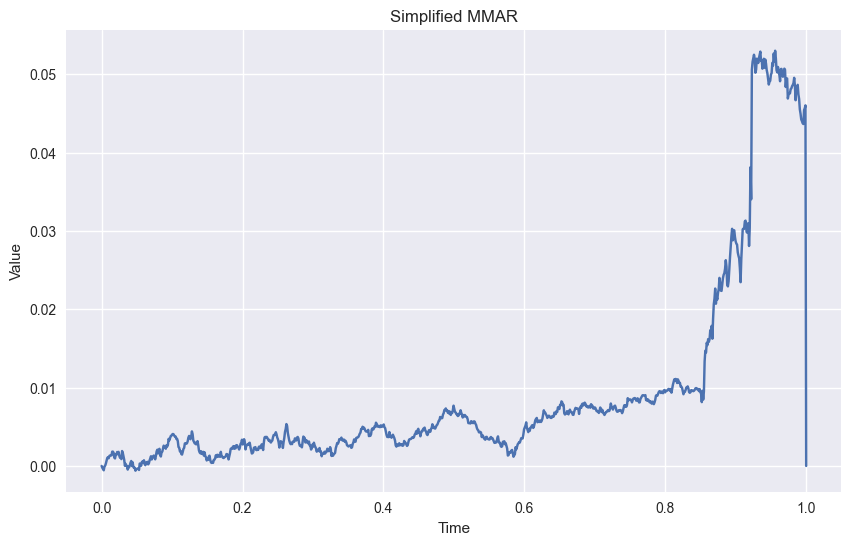

In [45]:
def generate_multifractal_measure(hurst, num_intervals):
    """
    This function generates a multifractal measure using a multiplicative cascade.
    The weights of the subintervals are correlated, and their correlation is controlled by the Hurst parameter.
    """
    
    # Initialize measure with one interval [0, 1]
    measure = [(0, 1)]
    
    for _ in range(num_intervals):
        # Choose a random interval from measure
        index = np.random.randint(len(measure))
        a, b = measure.pop(index)
        
        # Choose a random point in the interval according to Beta distribution
        split_point = np.random.beta(a=hurst, b=hurst)
        
        # Add new intervals to measure
        measure.append((a, a + split_point * (b - a)))
        measure.append((a + split_point * (b - a), b))
    
    # Sort measure by interval start time
    measure.sort(key=lambda x: x[0])
    
    return measure

def generate_MMAR(hurst, num_intervals, mu, sigma, T, N):
    """
    This function generates a time series using the MMAR.
    """
    
    # Generate multifractal measure
    measure = generate_multifractal_measure(hurst, num_intervals)
    
    # Initialize MMAR
    MMAR = np.zeros(N)
    dt = T/N
    time_stamps = np.linspace(0, T, N)
    
    # Apply measure to time series
    for i in range(1, N):
        for a, b in measure:
            if a <= time_stamps[i] < b:
                MMAR[i] = MMAR[i-1] + np.sqrt(dt / (b - a)) * np.random.normal(mu * dt, sigma * np.sqrt(dt))
    
    return MMAR

# Set the parameters
hurst = 0.75
num_intervals = 10
mu = 0.1
sigma = 0.2
T = 1
N = 1000

# Generate MMAR
MMAR = generate_MMAR(hurst, num_intervals, mu, sigma, T, N)

# Plot the MMAR
plt.figure(figsize=(10, 6))
plt.plot(np.linspace(0, T, N), MMAR)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Simplified MMAR')
plt.show()

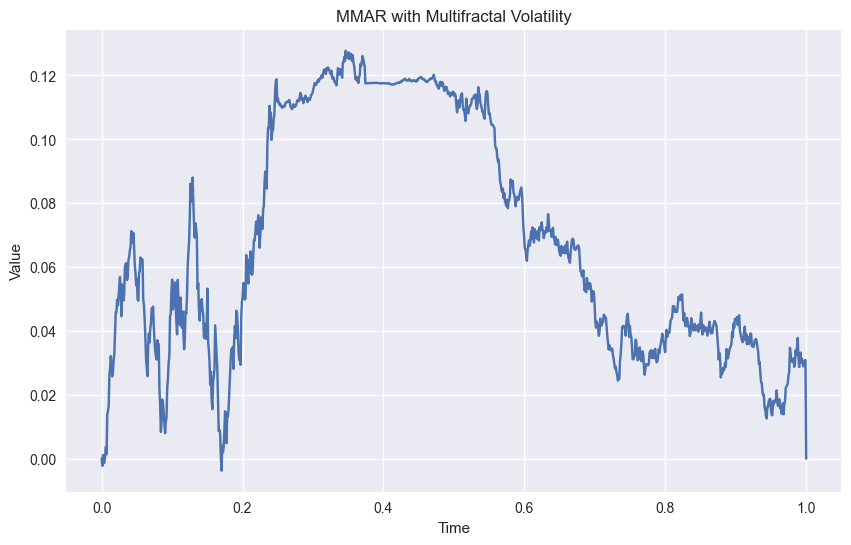

In [46]:
def generate_multifractal_measure(hurst, num_intervals):
    """
    This function generates a binomial multifractal measure using a multiplicative cascade.
    """
    alpha = 0.5 + hurst / 2
    beta = 0.5 - hurst / 2
    
    # Initialize measure with one interval [0, 1] and weight 1
    measure = [(0, 1, 1)]
    
    for _ in range(num_intervals):
        # Choose a random interval from measure
        index = np.random.randint(len(measure))
        a, b, w = measure.pop(index)
        
        # Generate a binomial random variable
        p = np.random.binomial(n=1, p=0.5)
        
        # Calculate new weights
        w_alpha = w * alpha if p == 1 else w * beta
        w_beta = w * beta if p == 1 else w * alpha
        
        # Add new intervals to measure
        measure.append((a, a + 0.5 * (b - a), w_alpha))
        measure.append((a + 0.5 * (b - a), b, w_beta))
    
    # Sort measure by interval start time
    measure.sort(key=lambda x: x[0])
    
    return measure

def generate_MMAR(hurst, num_intervals, mu, sigma, T, N):
    """
    This function generates a time series using the MMAR, with volatility as a function of the trading time.
    """
    # Generate multifractal measure
    measure = generate_multifractal_measure(hurst, num_intervals)
    
    # Initialize MMAR
    MMAR = np.zeros(N)
    dt = T / N
    time_stamps = np.linspace(0, T, N)
    
    # Apply measure to time series
    for i in range(1, N):
        for a, b, w in measure:
            if a <= time_stamps[i] < b:
                dW = np.random.normal(0, np.sqrt(dt))
                volatility = sigma * np.sqrt(w)
                MMAR[i] = MMAR[i-1] + mu * w * dt + volatility * dW
    
    return MMAR

# Set the parameters
hurst = 0.75
num_intervals = 10
mu = 0.1
sigma = 0.2
T = 1
N = 1000

# Generate MMAR
MMAR = generate_MMAR(hurst, num_intervals, mu, sigma, T, N)

# Plot the MMAR
plt.figure(figsize=(10, 6))
plt.plot(np.linspace(0, T, N), MMAR)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('MMAR with Multifractal Volatility')
plt.show()

#### Attempt to Calculate the necessary Fractal Parameters for the Simulations

We will be loading a longer price series of WTI prices as the yahoo finance API had limited datapoints. 

In [17]:
prices = pd.read_csv('wti_2nb_price_data.csv', index_col=0, parse_dates=True)

In [18]:
prices.describe()

,Close
count,8437.000000
mean,50.153045
std,29.407302
min,11.020000
25%,21.720000
50%,46.320000
75%,72.260000
max,145.860000


In [19]:
prices['returns'] = np.log(prices['Close']/prices['Close'].shift(1))

In [20]:
returns = prices['returns']

In [48]:
returns.dropna(inplace=True)

In [49]:
returns

Date
1990-01-03    0.024682
1990-01-04   -0.019341
1990-01-05   -0.022443
1990-01-08   -0.046455
1990-01-09    0.009465
                ...   
2023-07-19   -0.004902
2023-07-20    0.004770
2023-07-21    0.014827
2023-07-24    0.020880
2023-07-25    0.012800
Name: returns, Length: 8406, dtype: float64

In [50]:
# Selecting a highly composite number (7560) of observations
returns_ = returns.iloc[:7561]

In [52]:
returns_.describe()

count    7561.000000
mean        0.000041
std         0.021886
min        -0.384071
25%        -0.011050
50%         0.000554
75%         0.011481
max         0.134193
Name: returns, dtype: float64

In [53]:
# Define the sequence ranges
ranges = [
    np.arange(0.01, 0.6, 0.1),
    np.arange(0.55, 0.6, 0.05),
    np.arange(0.6, 1.81, 0.05),
    np.arange(1.81, 1.91, 0.01),
    np.array(list(np.arange(1.91, 1.99, 0.01)) + [1.985]),
    np.arange(1.991, 2.001, 0.001),
    np.arange(2.001, 2.011, 0.001),
    np.arange(2.015, 2.021, 0.005),
    np.arange(2.02, 2.1, 0.01),
    np.arange(2.1, 2.51, 0.05),
    np.arange(2.6, 3.0, 0.1),
    np.arange(3.0, 4.0, 0.1),
    np.arange(4.0, 4.6, 0.5),
    np.arange(5.0, 11.0, 1),
    np.arange(12.5, 27.6, 2.5),
    np.arange(30, 30.1, 2.5)
]

# Concat ranges in one
q = np.concatenate(ranges)
q

array([1.000e-02, 1.100e-01, 2.100e-01, 3.100e-01, 4.100e-01, 5.100e-01,
       5.500e-01, 6.000e-01, 6.500e-01, 7.000e-01, 7.500e-01, 8.000e-01,
       8.500e-01, 9.000e-01, 9.500e-01, 1.000e+00, 1.050e+00, 1.100e+00,
       1.150e+00, 1.200e+00, 1.250e+00, 1.300e+00, 1.350e+00, 1.400e+00,
       1.450e+00, 1.500e+00, 1.550e+00, 1.600e+00, 1.650e+00, 1.700e+00,
       1.750e+00, 1.800e+00, 1.810e+00, 1.820e+00, 1.830e+00, 1.840e+00,
       1.850e+00, 1.860e+00, 1.870e+00, 1.880e+00, 1.890e+00, 1.900e+00,
       1.910e+00, 1.920e+00, 1.930e+00, 1.940e+00, 1.950e+00, 1.960e+00,
       1.970e+00, 1.980e+00, 1.990e+00, 1.985e+00, 1.991e+00, 1.992e+00,
       1.993e+00, 1.994e+00, 1.995e+00, 1.996e+00, 1.997e+00, 1.998e+00,
       1.999e+00, 2.000e+00, 2.001e+00, 2.002e+00, 2.003e+00, 2.004e+00,
       2.005e+00, 2.006e+00, 2.007e+00, 2.008e+00, 2.009e+00, 2.010e+00,
       2.011e+00, 2.015e+00, 2.020e+00, 2.020e+00, 2.030e+00, 2.040e+00,
       2.050e+00, 2.060e+00, 2.070e+00, 2.080e+00, 

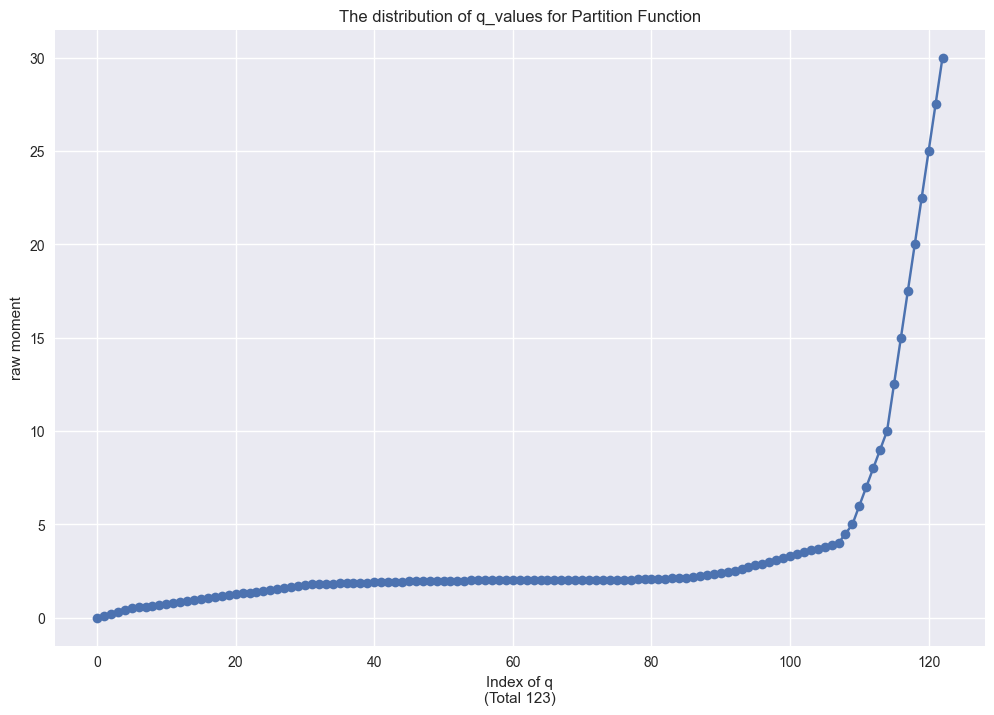

In [54]:
# Plotting q_values
plt.figure(figsize=(12,8))
plt.grid(True)
plt.title("The distribution of q_values for Partition Function")
plt.xlabel(f"Index of q\n(Total {len(q)})")
plt.ylabel('raw moment')
plt.plot(q, marker='o')
plt.show()

In [55]:
def generate_sequence():
    return (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 18, 20, 21, 24, 27, 28, 30, 35, 36, 40, 42, 45, 54, 56, 60, 63, 70, 72, 84, 90, 105,
            108, 120, 126, 135, 140, 168, 180, 189, 210, 216, 252, 270, 280, 315, 360, 378, 420, 504, 540, 630, 756, 840, 945, 1080, 1260, 
            1512, 1890, 2520, 3780, 7560)

dt = generate_sequence()

In [ ]:
def calculate_partition_function(ts, q_values, dt_values):
    Z = np.zeros((len(q_values), len(dt_values)))

    # Loop over q values
    for i, q in enumerate(q_values):
        # Loop over dt values
        for j, dt in enumerate(dt_values):
            # Split the time series into non-overlapping segments of size dt
            segments = np.array_split(ts, len(ts) // dt)

            # Calculate the partition function for this q and dt
            Z[i, j] = np.sum([np.sum(np.abs(segment)**q) for segment in segments])

    return Z

In [ ]:
Z = calculate_partition_function(returns_, q, dt)

# Plot the partition function
plt.figure(figsize=(10, 6))
plt.contourf(dt_values, q_values, Z, cmap='jet')
plt.colorbar(label='Z(q, dt)')
plt.xlabel('dt')
plt.ylabel('q')
plt.title('Partition Function')
plt.grid(True)
plt.show()

#### An initial look at The existing python package

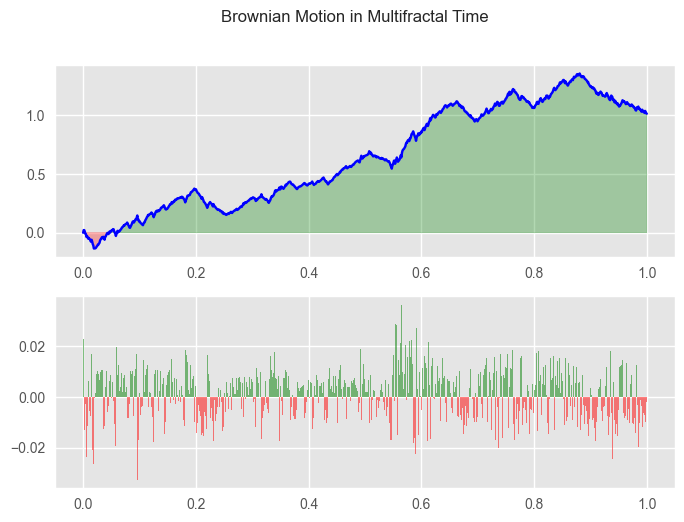

In [77]:
from fractalmarkets.mmar.brownian_motion_multifractal_time import BrownianMotionMultifractalTime
import matplotlib
import matplotlib.pyplot as plt; plt.style.use('ggplot')
from scipy import interpolate
import numpy as np

bmmt = BrownianMotionMultifractalTime(9, x=0.457, y=0.603, randomize_segments=True, randomize_time=True, M=[0.6, 0.4])
data = bmmt.simulate() # [ [x, y], ..., [x_n, y_n]]

f = interpolate.interp1d(data[:,0], data[:,1])

y = f(np.arange(0, 1, .001))
x = np.linspace(0, 1, len(y), endpoint=True)

y_diff = [b - a for a, b in zip(y[:-1], y[1:])]

fig, axs = plt.subplots(2)
fig.suptitle('Brownian Motion in Multifractal Time')

axs[0].plot(x, y, 'b-')
axs[1].bar(x[:-1],y_diff,align='edge',width=0.001,alpha=0.5)
bar_list=filter(lambda x: isinstance(x,matplotlib.patches.Rectangle),axs[1].get_children())
for bar,ret in zip(bar_list,y_diff):
    if ret >= 0:
        bar.set_facecolor('green')
    else:
        bar.set_facecolor('red')

z1 = np.array(y)
z2 = np.array([0] * len(y))

axs[0].fill_between(x, y, 0,
                where=(z1 >= z2),
                alpha=0.30, color='green', interpolate=True)

axs[0].fill_between(x, y, 0,
                where=(z1 < z2),
                alpha=0.30, color='red', interpolate=True)

plt.show()

In [83]:
test_multiplicative_cascade

<function __main__.test_multiplicative_cascade()>